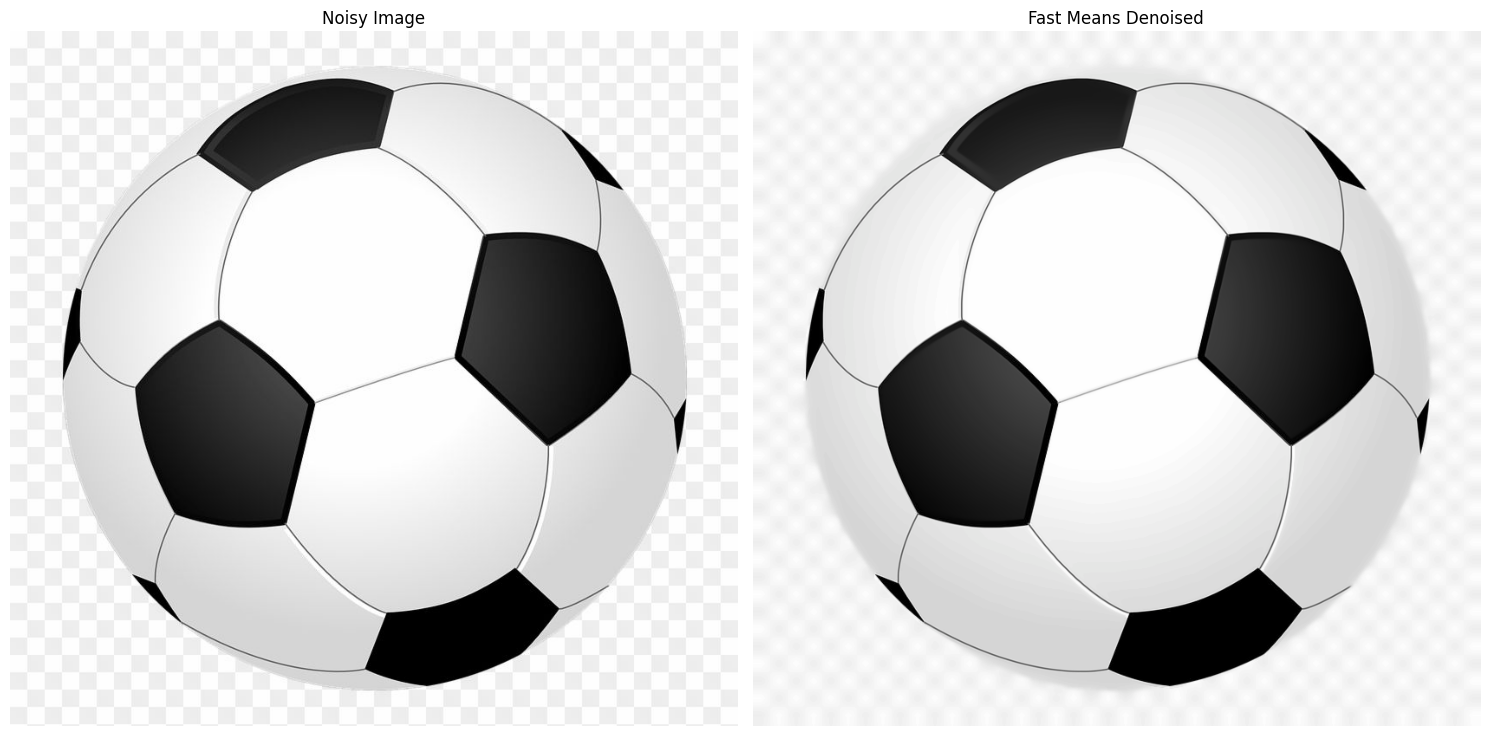

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread("football.jpg")

# Apply fast non-local means denoising
dst = cv2.fastNlMeansDenoisingColored(image, None, 11, 6, 7, 21)

# Create a figure with subplots
row, col = 1, 2
fig, axs = plt.subplots(row, col, figsize=(15, 10))

# Display original image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Noisy Image')
axs[0].axis('off')  # Hide axes

# Display denoised image
axs[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axs[1].set_title('Fast Means Denoised')
axs[1].axis('off')  # Hide axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


First we are importing different python libraries

In [1]:

import matplotlib
import numpy as np

# TkAgg here refers=> "Tk is the tkinter Gui library and where as the Agg is the anti grain geometry"
#here TkAgg is used by the matplotlib library as a backend for high dimensional rendering 
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# PIL is the python image library for opening and manuplating and saving the image in various formats
# image is a class from the PIL library for opening the image and processing it
from PIL import Image

# this is the used for importing the pytorch library 
# used for tensor operations, model training and inference used here for running depth estimation models
import torch

# transformers-> popular library from hugging face for working with pre trained models in computer vision and other tasks
# GLPNImageProcessor-> used for preprocessing the image like resizing the image, normalization and converting the image into a format that the model can understand
# GNPLForDepthEstimation-> image passed throug this defines the depth map of the image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

initializing a pretrained image image processor for preparing images from depth estiation

In [2]:
# here we are loading a pretrained weigth and configration from a specific repo from hugging face 
# ensures input image properly prea[ared before putting into the model
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")

# importing the repo from huggging face which will be used to create a depth map of the image 
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

In [3]:
image = Image.open("weird_bird.jpg")
h1 = image.width/image.height
print(h1)
print(image.width)
print(image.height)

1.4615384615384615
1216
832


Here we are loading and resizing an image 
Most of the image depth estimate models need image of a fixed size so to get a better performance of the model or they are trained as per that only

In [4]:

# using the Image function of the PIL library to open an image and manuplate its features
# like its height and width
image = Image.open("weird_bird.jpg")

# here we are changing the height and width of the image 
# image.heigth and image.width are the original height and width of the image 

# assigning the new heigth to the image i.e 480 if the image height is less than 480
# otherwise keep it to original
# next we are 
new_height = 480 if image.height > 480 else image.height

# finding the new height of the image so that it is divisible by 32
new_height -= (new_height % 32)

# since the original width and height of the image is same so we are assigning the new_height to the new_width so that it also becoomes same
new_width = int(new_height * image.width / image.height)

# if there is any difference between the nearest divisibility of 32 
diff = new_width % 32

# now assigning the new width 
# if the difference is less than 16 then diff subtracted if graeater than 32 then add the the difference of diff and 32 to new_width 
new_width = new_width - diff if diff < 16 else new_width + 32 - diff

# assigning the new height and width to the image using the resize function of the image class of PIL library
# also the resize function takes a tuple of the form (width,height)
new_size = (new_width,new_height)
image = image.resize(new_size)

In this we will extract tensor information from the preprocessed image which will be suitable for the pytorch library

In [5]:
# preparing the image for the model

inputs = feature_extractor(images = image,return_tensors = "pt")

# now image is converted from its raw format into tensor format that the model can work with

In [6]:
# getting the prediction from the model

# this context manager is used is used to disable gradient tracking in pytorch
# when forward passes are needed through a model the gradient will automatically calculate differentiation which is useful during training
# as here we are doing inference so we don't need this 

with torch.no_grad():

# the predicted depth map and some more information is stored in the outputs
    outputs = model(**inputs) # the GLPNDepthEstimation model processes the input tensors and produces an output which typically contains the predicted depth map and other information

# extracts the relevant depth information 
    predicted_depth = outputs.predicted_depth
    

postprocessing the depth prediction and visualizing the original image and predicted depth map

In [7]:
# postprocessing

# padding removes the edges of the image as model might not be able to predict correctly due to boundary effects

pad = 16

#squeeze() is used for dimensionality reduction for removing 1 from the tensors
# .cpu this will move the tensors from the gpu memory to cpu memory as cpu memory can only access numpy library 
# .numpy will convert the tensor into a numpy array and at last each element in the array is multiplied by 1000 
output = predicted_depth.squeeze().cpu().numpy()*1000.0

# this line crops the depth output by removing the padding from the edges
# it removes 16 pixels from the top and bottom , left and right side
# helps in focusing on the central area where the predictions are more realiable
output = output[pad: -pad,pad:-pad]

# this crops the original image removing the area(left,upper,right,lower)
image = image.crop((pad,pad, image.width - pad,image.height - pad))

# visualize the prediction 
# this is used to create 2 graphs or plots in the same row

# ax array contains the references to the individual subplot axes 
# means both images are stored in the array ax
fig, ax = plt.subplots(1,2)

# displaying the cropped original image in the first subplot
ax[0].imshow(image)

# cleans the tick marks and labels on the axes for a cleaner visual presentation
ax[0].tick_params(left=False, bottom=False, labelbottom=False)

# this displays the cropped depth image in the second subplot
ax[1].imshow(output,cmap="plasma_r")
ax[1].tick_params(left=False, bottom=False, labelbottom = False)

# this function adjusts subplot layouts to minimize overlaps and ensure the content fits well in the figure
plt.tight_layout()

# this line pauses the display for 5 seconds as it will be used for displaying after the user cancel the screen then only further execution
plt.pause(5)

In [8]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
width,height = image.size

depth_image = (output *255/np.max(output)).astype("uint8")
image = np.array(image)

In [10]:
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,depth_o3d,convert_rgb_to_intensity=False)

In [11]:
# 9creating a camera
camera_intrensic = o3d.camera.PinholeCameraIntrinsic()
camera_intrensic.set_intrinsics(width,height,500,500,width/2,height/2)

In [12]:
# 10 creating o3d point cloud

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrensic)

o3d.visualization.draw_geometries([pcd_raw])

In [13]:
# 11 post_processing the 3d point cloud

# outliers
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20,std_ratio = 6.0,print_progress=False)
pcd = pcd_raw.select_by_index(ind)

# estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

In [14]:
# 12 surface reconstruction
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd,depth =10,n_threads=1)[0]

# rotate the mesh 
rotation = mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation,center=(0,0,0))

# visualization the mesh
o3d.visualization.draw_geometries([mesh],mesh_show_back_face =True)

In [15]:
o3d.io.write_triangle_mesh('../se_project output images/weird_bird_mesh_original.obj',mesh)

True

In [19]:
import open3d as o3d

mesh = o3d.io.read_triangle_mesh("../se_project output images/weird_bird_mesh_original.obj")

# Create a visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add the mesh to the visualizer
vis.add_geometry(mesh)

# Set the background color to black
vis.get_render_option().background_color = [0.0, 0.0, 0.0]

# Run the visualizer
vis.run()
vis.destroy_window()

In [17]:
# import open3d as o3d

# # Create a point cloud object
# pcd = o3d.geometry.PointCloud()

# # Assign points and colors (assuming you have them in numpy arrays)
# pcd.points = o3d.utility.Vector3dVector(points)
# pcd.colors = o3d.utility.Vector3dVector(colors)

# # Save the point cloud to a file (e.g., PLY format)
# o3d.io.write_point_cloud("output.ply", pcd)

In [18]:
mesh_uniform =mesh.paint_uniform_color([0.9,0.8,0.9])
mesh_uniform.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_uniform],mesh_show_back_face= True)

In [16]:
#13. 3d mesh export
o3d.io.write_triangle_mesh('../se_project output images/weird_bird_mesh.obj',mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True